# Assessing Autism from Eye Movements Using Deep Learning

**Author:** Tal Alfi  
**Advisor:** Prof. Ohad Ben-Shahar  
**Institution:** Ben-Gurion University of the Negev  

## Project Overview

This notebook implements machine learning and deep learning approaches to:
1. **Classify** children with ASD vs. typically developing controls
2. **Predict severity** of autism symptoms based on ADOS scores

The analysis uses eye-tracking data collected from ~450 children (ages 1–10) watching 90-second social videos.

## 1. Environment Setup and Imports

In [1]:
# Standard libraries
import os
import glob
import warnings
import json
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.graph_objects as go
import plotly.express as px

# Scientific computing
from scipy import stats, signal
from scipy.spatial import distance
from scipy.stats import entropy

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Deep Learning (we'll check which framework is available)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    DL_FRAMEWORK = 'pytorch'
    print("Using PyTorch for deep learning")
except ImportError:
    try:
        import tensorflow as tf
        from tensorflow import keras
        DL_FRAMEWORK = 'tensorflow'
        print("Using TensorFlow for deep learning")
    except ImportError:
        DL_FRAMEWORK = None
        print("No deep learning framework found. Install PyTorch or TensorFlow.")

# Set random seeds for reproducibility
np.random.seed(42)
if DL_FRAMEWORK == 'pytorch':
    torch.manual_seed(42)
elif DL_FRAMEWORK == 'tensorflow':
    tf.random.set_seed(42)

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(f"Python environment setup complete!")
print(f"Available CSV files: {len(glob.glob('files/*.csv'))}")

Using PyTorch for deep learning
Python environment setup complete!
Available CSV files: 7


## 2. Data Loading and Initial Exploration

Let's start by loading one sample file to understand the data structure.

In [2]:
# Get a list of all CSV files
csv_files = sorted(glob.glob('files/*.csv'))
print(f"Found {len(csv_files)} CSV files")
print("\nSample filenames:")
for f in csv_files[:3]:
    print(f"  - {os.path.basename(f)}")

# Load a sample file to explore structure
sample_file = csv_files[0]
print(f"\nLoading sample file: {os.path.basename(sample_file)}")
df_sample = pd.read_csv(sample_file)

print(f"\nDataframe shape: {df_sample.shape}")
print(f"\nColumn names:")
for i, col in enumerate(df_sample.columns):
    print(f"  {i+1:2d}. {col}")

Found 7 CSV files

Sample filenames:
  - 1017735502_unified_eye_metrics_Dinstein_Girls_90_SecX.csv
  - 1019729632_unified_eye_metrics_Dinstein_Girls_90_SecX.csv
  - 1021745887_unified_eye_metrics_Dinstein_Girls_90_SecX.csv

Loading sample file: 1017735502_unified_eye_metrics_Dinstein_Girls_90_SecX.csv

Dataframe shape: (45007, 24)

Column names:
   1. timestamp
   2. frame_number
   3. x_left
   4. y_left
   5. pupil_left
   6. x_right
   7. y_right
   8. pupil_right
   9. input
  10. cr_info
  11. cr_left
  12. cr_right
  13. head_movement_left_x
  14. head_movement_right_x
  15. head_movement_magnitude
  16. inter_pupil_distance
  17. gaze_velocity_left
  18. gaze_velocity_right
  19. is_fixation_left
  20. is_fixation_right
  21. is_saccade_left
  22. is_saccade_right
  23. is_blink_left
  24. is_blink_right


In [3]:
# Display basic info about the data
print("Data shape:", df_sample.shape)
print("\nFirst few rows:")
display(df_sample.head())

# Data types
print("\nData types:")
print(df_sample.dtypes)

Data shape: (45007, 24)

First few rows:


,timestamp,frame_number,x_left,y_left,pupil_left,x_right,y_right,pupil_right,input,cr_info,cr_left,cr_right,head_movement_left_x,head_movement_right_x,head_movement_magnitude,inter_pupil_distance,gaze_velocity_left,gaze_velocity_right,is_fixation_left,is_fixation_right,is_saccade_left,is_saccade_right,is_blink_left,is_blink_right
0,5025592,1,629.3,495.2,735.0,616.4,508.1,708.0,NaN,NaN,5807.0,6408.0,-5177.7,-5791.6,7768.603983,18.243355,250.000000,158.113883,True,True,False,False,False,False
1,5025594,1,629.6,494.8,735.0,616.5,508.4,708.0,NaN,NaN,5807.0,6408.0,-5177.4,-5791.5,7768.329486,18.883061,250.000000,158.113883,True,True,False,False,False,False
2,5025596,1,630.2,494.4,735.0,617.1,508.3,708.0,NaN,NaN,5807.0,6408.0,-5176.8,-5790.9,7767.482285,19.100262,360.555128,304.138127,True,True,False,False,False,False
3,5025598,1,630.8,494.1,734.0,617.6,508.1,708.0,NaN,NaN,5807.0,6408.0,-5176.2,-5790.4,7766.709638,19.241622,335.410197,269.258240,True,True,False,False,False,False
4,5025600,1,631.5,493.8,734.0,618.1,507.9,707.0,NaN,NaN,5807.0,6408.0,-5175.5,-5789.9,7765.870348,19.451735,380.788655,269.258240,True,True,False,False,False,False



Data types:
timestamp                    int64
frame_number                 int64
x_left                     float64
y_left                     float64
pupil_left                 float64
x_right                    float64
y_right                    float64
pupil_right                float64
input                      float64
cr_info                     object
cr_left                    float64
cr_right                   float64
head_movement_left_x       float64
head_movement_right_x      float64
head_movement_magnitude    float64
inter_pupil_distance       float64
gaze_velocity_left         float64
gaze_velocity_right        float64
is_fixation_left              bool
is_fixation_right             bool
is_saccade_left               bool
is_saccade_right              bool
is_blink_left                 bool
is_blink_right                bool
dtype: object


## 3. Data Quality Assessment

In [4]:
# Analyze missing data
missing_percentage = (df_sample.isnull().sum() / len(df_sample)) * 100
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing_Count': df_sample.isnull().sum().values,
    'Missing_Percentage': missing_percentage.values
}).sort_values('Missing_Percentage', ascending=False)

print("Missing data analysis:")
print(missing_df[missing_df['Missing_Percentage'] > 0])

# Identify columns to remove (>95% missing)
cols_to_remove = missing_df[missing_df['Missing_Percentage'] > 95]['Column'].tolist()
print(f"\n❌ Columns to remove (>95% missing): {cols_to_remove}")

# Create cleaned dataframe
df_cleaned = df_sample.drop(columns=cols_to_remove)
print(f"\n✅ Shape after cleaning: {df_sample.shape} → {df_cleaned.shape}")

Missing data analysis:
                     Column  Missing_Count  Missing_Percentage
8                     input          45007          100.000000
9                   cr_info          44171           98.142511
17      gaze_velocity_right            881            1.957473
13    head_movement_right_x            876            1.946364
15     inter_pupil_distance            876            1.946364
5                   x_right            876            1.946364
6                   y_right            876            1.946364
7               pupil_right            876            1.946364
14  head_movement_magnitude            876            1.946364
16       gaze_velocity_left            576            1.279801
12     head_movement_left_x            572            1.270913
4                pupil_left            571            1.268692
3                    y_left            571            1.268692
2                    x_left            571            1.268692
11                 cr_right     

## 4. Understanding Eye-Tracking Columns

In [5]:
# Let's understand the key eye-tracking columns
print("🔍 Key Eye-Tracking Columns:\n")

# Coordinate columns
coord_cols = ['x_left', 'y_left', 'x_right', 'y_right']
print("1. Gaze Coordinates:")
for col in coord_cols:
    print(f"   {col}: min={df_cleaned[col].min():.2f}, max={df_cleaned[col].max():.2f}, "
          f"missing={df_cleaned[col].isnull().sum()} ({(df_cleaned[col].isnull().sum()/len(df_cleaned)*100):.1f}%)")

# Pupil columns  
print("\n2. Pupil Data:")
pupil_cols = ['pupil_left', 'pupil_right']
for col in pupil_cols:
    print(f"   {col}: min={df_cleaned[col].min():.2f}, max={df_cleaned[col].max():.2f}, "
          f"missing={df_cleaned[col].isnull().sum()} ({(df_cleaned[col].isnull().sum()/len(df_cleaned)*100):.1f}%)")

# Event columns
print("\n3. Event Detection (binary flags):")
event_cols = ['is_fixation_left', 'is_fixation_right', 'is_saccade_left', 'is_saccade_right', 'is_blink_left', 'is_blink_right']
for col in event_cols:
    print(f"   {col}: unique values = {df_cleaned[col].unique()}")

# Velocity columns
print("\n4. Gaze Velocity:")
vel_cols = ['gaze_velocity_left', 'gaze_velocity_right']
for col in vel_cols:
    print(f"   {col}: min={df_cleaned[col].min():.2f}, max={df_cleaned[col].max():.2f}, "
          f"missing={df_cleaned[col].isnull().sum()} ({(df_cleaned[col].isnull().sum()/len(df_cleaned)*100):.1f}%)")

🔍 Key Eye-Tracking Columns:

1. Gaze Coordinates:
   x_left: min=-357.90, max=2522.10, missing=571 (1.3%)
   y_left: min=-546.70, max=1839.50, missing=571 (1.3%)
   x_right: min=-860.90, max=2167.00, missing=876 (1.9%)
   y_right: min=-151.30, max=2009.70, missing=876 (1.9%)

2. Pupil Data:
   pupil_left: min=36.00, max=748.00, missing=571 (1.3%)
   pupil_right: min=38.00, max=717.00, missing=876 (1.9%)

3. Event Detection (binary flags):
   is_fixation_left: unique values = [ True False]
   is_fixation_right: unique values = [ True False]
   is_saccade_left: unique values = [False  True]
   is_saccade_right: unique values = [False  True]
   is_blink_left: unique values = [False  True]
   is_blink_right: unique values = [False  True]

4. Gaze Velocity:
   gaze_velocity_left: min=0.00, max=464847.37, missing=576 (1.3%)
   gaze_velocity_right: min=0.00, max=651683.10, missing=881 (2.0%)


## 5. Temporal Analysis - Understanding the Recording

In [6]:
# Let's understand the temporal aspects of the recording
print("📊 Temporal Analysis:")

# Convert timestamp to datetime if needed
df_cleaned['timestamp_dt'] = pd.to_datetime(df_cleaned['timestamp'], unit='ms', errors='coerce')

# Recording duration
duration_ms = df_cleaned['timestamp'].max() - df_cleaned['timestamp'].min()
duration_sec = duration_ms / 1000
print(f"\nRecording duration: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")

# Sampling rate
time_diffs = df_cleaned['timestamp'].diff().dropna()
mean_interval = time_diffs.mean()
sampling_rate = 1000 / mean_interval  # Hz
print(f"Average sampling rate: {sampling_rate:.2f} Hz")
print(f"Expected samples for 90 seconds at 500Hz: {90 * 500}")
print(f"Actual samples: {len(df_cleaned)}")

# Check if we have the full 90 seconds
if duration_sec < 85:  # Allow some tolerance
    print(f"\n⚠️ Warning: Recording is shorter than expected 90 seconds!")

📊 Temporal Analysis:

Recording duration: 90.01 seconds (1.50 minutes)
Average sampling rate: 500.00 Hz
Expected samples for 90 seconds at 500Hz: 45000
Actual samples: 45007


bbb## 6. Visualizing Gaze Patterns

In [7]:
SCREEN_WIDTH = 1280
SCREEN_HEIGHT = 1024
SAMPLING_RATE = 500

## 6. Visualizing Raw Data - One Step at a Time

### 6.1 Gaze Trajectory Plot

In [8]:
def plot_trajectory(df_cleaned):
    # Create gaze trajectory plot
    plt.figure(figsize=(10, 8))

    # Get valid data for each eye
    left_valid = df_cleaned.dropna(subset=['x_left', 'y_left'])
    right_valid = df_cleaned.dropna(subset=['x_right', 'y_right'])

    # Plot gaze points
    plt.scatter(left_valid['x_left'], left_valid['y_left'],
               c='blue', alpha=0.3, s=1, label=f'Left eye')
    plt.scatter(right_valid['x_right'], right_valid['y_right'],
               c='red', alpha=0.3, s=1, label=f'Right eye')

    plt.axhline(y=0, color='black', linewidth=2)
    plt.axhline(y=SCREEN_HEIGHT, color='black', linewidth=2)
    plt.axvline(x=0, color='black', linewidth=2)
    plt.axvline(x=SCREEN_WIDTH, color='black', linewidth=2)

    plt.xlim(-200, SCREEN_WIDTH + 200)
    plt.ylim(-200, SCREEN_HEIGHT + 200)
    plt.xlabel('X coordinate (pixels)')
    plt.ylabel('Y coordinate (pixels)')
    plt.title(f'Gaze Trajectory - Subject {os.path.basename(sample_file).split("_")[0]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().invert_yaxis()

    plt.tight_layout()

    plt.show()

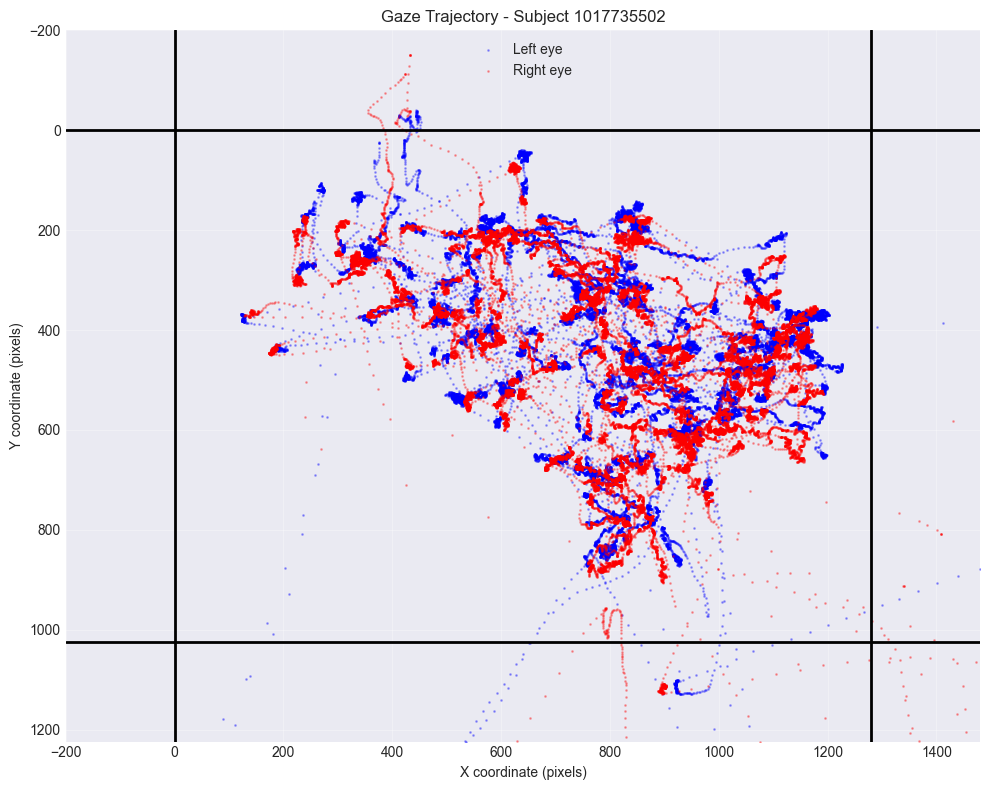

In [9]:
plot_trajectory(df_cleaned)

#### what's good?
   - **The binocular data** (both eyes) is visible and mostly overlapping, which
   suggests decent calibration
  - Most gaze points fall within screen boundaries
  - Clear concentration in central viewing area

#### Future Data Cleaning Strategy

- **Out-of-bounds filtering**: Remove points outside screen boundaries (0-1280, 0-1024)
- **Monocular outliers**: Exclude single-eye data points that are spatially isolated from fixation clusters
- **Edge tolerance**: Apply small margin (-20 pixels) to preserve legitimate edge-viewing behavior

In [10]:
def add_cleaning_help_features(df_cleaned):# Calculate basic quality metrics for visualization
    # Velocity (helps identify saccades, blinks, and tracking errors)
    df_cleaned['velocity_left'] = np.sqrt(
        df_cleaned['x_left'].diff()**2 +
        df_cleaned['y_left'].diff()**2
    ) * SAMPLING_RATE

    df_cleaned['velocity_right'] = np.sqrt(
        df_cleaned['x_right'].diff()**2 +
        df_cleaned['y_right'].diff()**2
    ) * SAMPLING_RATE

    # Binocular disparity (reveals calibration issues)
    df_cleaned['disparity_x'] = df_cleaned['x_left'] - df_cleaned['x_right']
    df_cleaned['disparity_y'] = df_cleaned['y_left'] - df_cleaned['y_right']
    df_cleaned['disparity_total'] = np.sqrt(
        df_cleaned['disparity_x']**2 +
        df_cleaned['disparity_y']**2
    )

    # Data validity flags
    df_cleaned['both_eyes_valid'] = (
        df_cleaned['x_left'].notna() &
        df_cleaned['x_right'].notna()
    )

    # Out of bounds flags
    df_cleaned['left_in_bounds'] = (
        (df_cleaned['x_left'] >= -20) & (df_cleaned['x_left'] <= SCREEN_WIDTH + 20) &
        (df_cleaned['y_left'] >= -20) & (df_cleaned['y_left'] <= SCREEN_HEIGHT + 20)
    )

    df_cleaned['right_in_bounds'] = (
        (df_cleaned['x_right'] >= -20) & (df_cleaned['x_right'] <= SCREEN_WIDTH + 20) &
        (df_cleaned['y_right'] >= -20) & (df_cleaned['y_right'] <= SCREEN_HEIGHT + 20)
    )

    df_cleaned['time_seconds'] = (df_cleaned['timestamp'] - df_cleaned['timestamp'].iloc[0]) / 1000.0

In [11]:
add_cleaning_help_features(df_cleaned)

In [12]:
# Check column names and use the timestamp column
print("Available columns:", df_cleaned.columns.tolist())
time_col = 'timestamp' if 'timestamp' in df_cleaned.columns else df_cleaned.index

Available columns: ['timestamp', 'frame_number', 'x_left', 'y_left', 'pupil_left', 'x_right', 'y_right', 'pupil_right', 'cr_left', 'cr_right', 'head_movement_left_x', 'head_movement_right_x', 'head_movement_magnitude', 'inter_pupil_distance', 'gaze_velocity_left', 'gaze_velocity_right', 'is_fixation_left', 'is_fixation_right', 'is_saccade_left', 'is_saccade_right', 'is_blink_left', 'is_blink_right', 'timestamp_dt', 'velocity_left', 'velocity_right', 'disparity_x', 'disparity_y', 'disparity_total', 'both_eyes_valid', 'left_in_bounds', 'right_in_bounds', 'time_seconds']


In [13]:
def extract_and_plot_binocular_saccades(df_cleaned):
    """
    Extract binocular saccades from the data and plot their amplitudes over time.

    Args:
        df_cleaned (pd.DataFrame): DataFrame containing:
            - 'time_seconds', 'x_left', 'y_left', 'x_right', 'y_right'
            - 'is_saccade_left', 'is_saccade_right'

    Returns:
        pd.DataFrame: A DataFrame of detected saccade events.
    """
    saccade_events = []

    in_saccade = False
    saccade_start_x_left = None
    saccade_start_y_left = None
    saccade_start_x_right = None
    saccade_start_y_right = None
    saccade_start_time = None

    for idx, row in df_cleaned.iterrows():
        both_eyes_saccade = (row['is_saccade_left'] == True) and (row['is_saccade_right'] == True)

        if both_eyes_saccade and not in_saccade:
            in_saccade = True
            saccade_start_x_left = row['x_left']
            saccade_start_y_left = row['y_left']
            saccade_start_x_right = row['x_right']
            saccade_start_y_right = row['y_right']
            saccade_start_time = row['time_seconds']

        elif not both_eyes_saccade and in_saccade:
            if pd.notna(saccade_start_x_left) and pd.notna(row['x_left']) and \
               pd.notna(saccade_start_x_right) and pd.notna(row['x_right']):

                distance_left = np.sqrt((row['x_left'] - saccade_start_x_left) ** 2 +
                                        (row['y_left'] - saccade_start_y_left) ** 2)
                distance_right = np.sqrt((row['x_right'] - saccade_start_x_right) ** 2 +
                                         (row['y_right'] - saccade_start_y_right) ** 2)

                avg_distance = (distance_left + distance_right) / 2
                duration = row['time_seconds'] - saccade_start_time

                saccade_events.append({
                    'start_time': saccade_start_time,
                    'end_time': row['time_seconds'],
                    'duration_ms': duration * 1000,
                    'amplitude_pixels': avg_distance,
                    'amplitude_left': distance_left,
                    'amplitude_right': distance_right,
                    'amplitude_difference': abs(distance_left - distance_right),
                    'start_x_left': saccade_start_x_left,
                    'start_y_left': saccade_start_y_left,
                    'end_x_left': row['x_left'],
                    'end_y_left': row['y_left']
                })

            in_saccade = False

    saccades_df = pd.DataFrame(saccade_events)

    print(f"Total binocular saccades detected: {len(saccades_df)}")
    if len(saccades_df) > 0:
        print(f"Average saccade amplitude: {saccades_df['amplitude_pixels'].mean():.1f} pixels")
        print(f"Average saccade duration: {saccades_df['duration_ms'].mean():.1f} ms")
        print(f"Average amplitude difference between eyes: {saccades_df['amplitude_difference'].mean():.1f} pixels")

        plt.figure(figsize=(15, 6))
        plt.scatter(saccades_df['start_time'], saccades_df['amplitude_pixels'],
                    alpha=0.6, s=20, c='darkblue', label='Average amplitude')
        plt.scatter(saccades_df['start_time'], saccades_df['amplitude_left'],
                    alpha=0.3, s=10, c='blue', label='Left eye')
        plt.scatter(saccades_df['start_time'], saccades_df['amplitude_right'],
                    alpha=0.3, s=10, c='red', label='Right eye')

        plt.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Small saccade')
        plt.axhline(y=500, color='orange', linestyle='--', alpha=0.5, label='Medium saccade')
        plt.axhline(y=1000, color='red', linestyle='--', alpha=0.5, label='Large saccade')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Saccade Amplitude (pixels)')
        plt.title('Binocular Saccade Amplitudes Throughout 90-Second Recording')
        plt.xlim(0, 90)
        plt.ylim(0, saccades_df['amplitude_pixels'].quantile(0.95) * 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No binocular saccades found in the data.")

    return saccades_df

Total binocular saccades detected: 139
Average saccade amplitude: 237.6 pixels
Average saccade duration: 42.9 ms
Average amplitude difference between eyes: 33.7 pixels


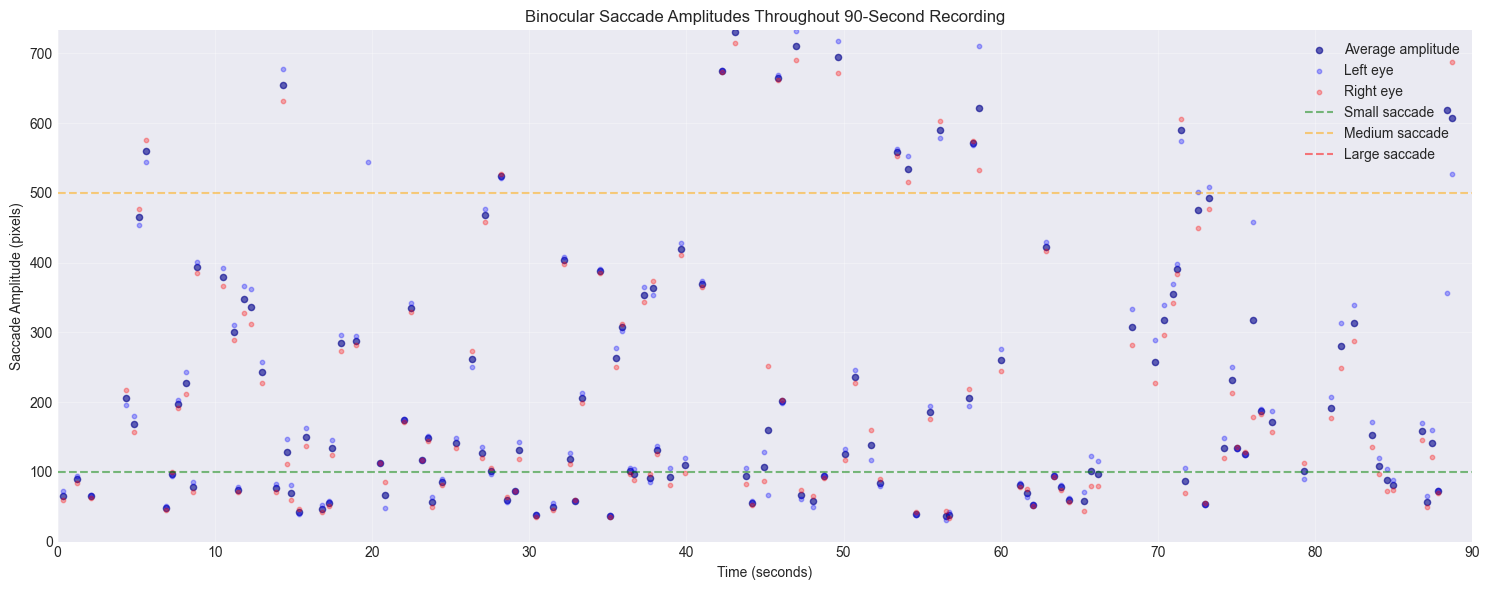

In [14]:
saccades_df = extract_and_plot_binocular_saccades(df_cleaned)

Average amplitude difference between eyes: 33.7 pixels - may raise some concerns since this value seems too high. lets investigate further

In [15]:
def analyze_binocular_disparity(df, ax=None, title_suffix=""):
    """
    Analyze and visualize binocular disparity over time.
    Modified to work with subplots - can pass an axis object.

    Args:
        df (pd.DataFrame): DataFrame containing at least:
            - 'time_seconds'
            - 'disparity_total'
        ax (matplotlib.axes): Axis to plot on, or None to create new figure
        title_suffix (str): Additional text to add to the title
    """
    if ax is None:
        plt.figure(figsize=(15, 6))
        ax = plt.gca()

    # Plot disparity over time
    ax.plot(df['time_seconds'], df['disparity_total'],
            color='purple', alpha=0.7, linewidth=0.5)
    ax.axhline(y=10, color='green', linestyle='--', label='Good calibration (<10 pixels)')
    ax.axhline(y=30, color='orange', linestyle='--', label='Acceptable (<30 pixels)')
    ax.axhline(y=50, color='red', linestyle='--', label='Poor calibration (>50 pixels)')

    # Highlight high-disparity periods
    high_disparity = df[df['disparity_total'] > 100]
    ax.scatter(high_disparity['time_seconds'], high_disparity['disparity_total'],
               color='red', s=10, alpha=0.5, label='Very high disparity')

    ax.set_ylabel('Binocular Disparity (pixels)')
    ax.set_xlabel('Time (seconds)')
    title = 'Binocular Disparity Throughout Recording'
    if title_suffix:
        title += f' - {title_suffix}'
    ax.set_title(title)
    ax.set_ylim(0, 200)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Calculate statistics to return
    mean_disp = df['disparity_total'].mean()
    median_disp = df['disparity_total'].median()
    percent_over_50 = (df['disparity_total'] > 50).mean() * 100
    percent_over_100 = (df['disparity_total'] > 100).mean() * 100

    stats = {
        'mean_disparity': mean_disp,
        'median_disparity': median_disp,
        'percent_over_50': percent_over_50,
        'percent_over_100': percent_over_100
    }

    return stats


{'mean_disparity': np.float64(39.668134737998855),
 'median_disparity': np.float64(28.76404005003467),
 'percent_over_50': np.float64(18.04830359721821),
 'percent_over_100': np.float64(4.285999955562468)}

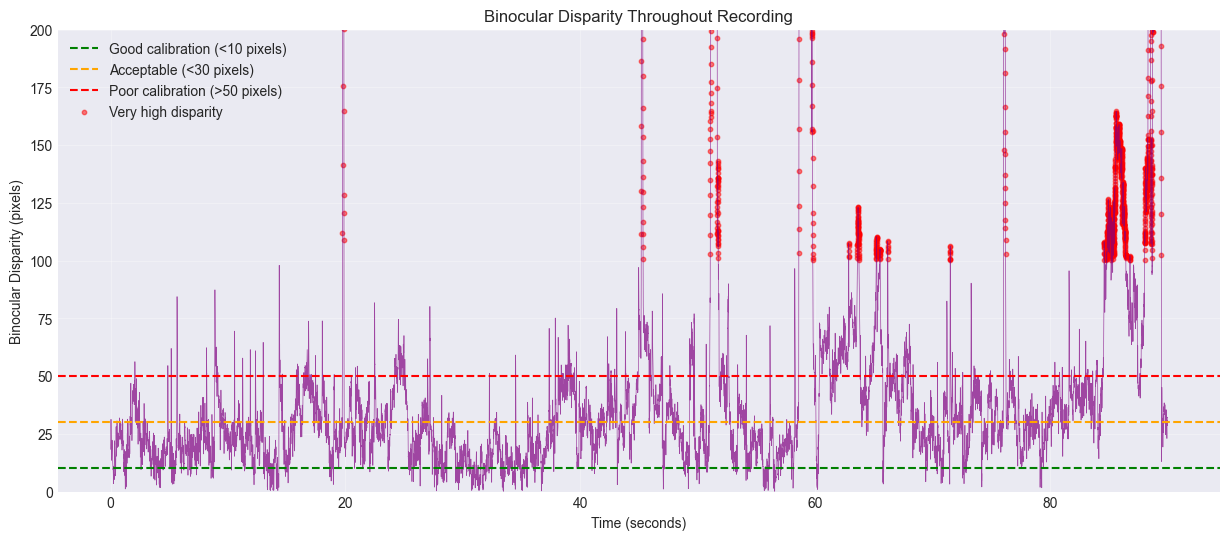

In [16]:
analyze_binocular_disparity(df_cleaned)


In [17]:
# automatically corrects small alignment (calibration) errors between the left and right eyes in binocular eye-tracking data.
def automatic_binocular_calibration(df,
                                   velocity_threshold=100,
                                   disparity_percentile=50,
                                   verbose=True):
    df = df.copy()

    # Calculate velocities if not already present
    if 'velocity_left' not in df.columns:
        df['velocity_left'] = np.sqrt(
            df['x_left'].diff()**2 + df['y_left'].diff()**2
        ) * 500  # 500Hz sampling rate

    if 'velocity_right' not in df.columns:
        df['velocity_right'] = np.sqrt(
            df['x_right'].diff()**2 + df['y_right'].diff()**2
        ) * 500

    # Find stable periods (low velocity for both eyes)
    stable_mask = (
        (df['velocity_left'] < velocity_threshold) &
        (df['velocity_right'] < velocity_threshold) &
        df['x_left'].notna() &
        df['x_right'].notna() &
        df['y_left'].notna() &
        df['y_right'].notna()
    )

    stable_samples = stable_mask.sum()

    # Calculate disparities during stable periods
    stable_data = df[stable_mask]
    x_disparity = stable_data['x_left'] - stable_data['x_right']
    y_disparity = stable_data['y_left'] - stable_data['y_right']

    # Calculate robust bias estimates
    x_bias = np.percentile(x_disparity, disparity_percentile)
    y_bias = np.percentile(y_disparity, disparity_percentile)


    # For symmetry, we'll split the correction between both eyes
    x_correction_left = x_bias / 2
    y_correction_left = y_bias / 2
    x_correction_right = -x_bias / 2
    y_correction_right = -y_bias / 2

    # Apply corrections
    df['x_left'] = df['x_left'] - x_correction_left
    df['y_left'] = df['y_left'] - y_correction_left
    df['x_right'] = df['x_right'] - x_correction_right
    df['y_right'] = df['y_right'] - y_correction_right

    # Recalculate disparities with corrected values
    df['disparity_x'] = df['x_left'] - df['x_right']
    df['disparity_y'] = df['y_left'] - df['y_right']
    df['disparity_total'] = np.sqrt(
        df['disparity_x']**2 + df['disparity_y']**2
    )

    # Calculate improvement metrics
    original_disparity = np.sqrt(x_disparity**2 + y_disparity**2).median()
    corrected_disparity = df.loc[stable_mask, 'disparity_total'].median()
    improvement = (1 - corrected_disparity / original_disparity) * 100

    correction_info = {
        'x_bias': x_bias,
        'y_bias': y_bias,
        'stable_samples': stable_samples,
        'original_disparity': original_disparity,
        'corrected_disparity': corrected_disparity,
        'improvement_percent': improvement,
        'x_correction_left': x_correction_left,
        'y_correction_left': y_correction_left,
        'x_correction_right': x_correction_right,
        'y_correction_right': y_correction_right
    }

    if verbose:
        print("🔧 Automatic Binocular Calibration Correction")
        print("=" * 50)
        print(f"Detected biases (based on {stable_samples} stable samples):")
        print(f"  Horizontal: {x_bias:.1f} pixels")
        print(f"  Vertical: {y_bias:.1f} pixels")
        print(f"\nCorrection applied (split between eyes):")
        print(f"  Left eye:  ({x_correction_left:.1f}, {y_correction_left:.1f}) pixels")
        print(f"  Right eye: ({x_correction_right:.1f}, {y_correction_right:.1f}) pixels")
        print(f"\nResults:")
        print(f"  Original disparity: {original_disparity:.1f} pixels")
        print(f"  Corrected disparity: {corrected_disparity:.1f} pixels")
        print(f"  Improvement: {improvement:.1f}%")

    return df, correction_info

In [18]:
df_corrected,correction_info = automatic_binocular_calibration(df_cleaned)

🔧 Automatic Binocular Calibration Correction
Detected biases (based on 113 stable samples):
  Horizontal: -1.0 pixels
  Vertical: -17.7 pixels

Correction applied (split between eyes):
  Left eye:  (-0.5, -8.8) pixels
  Right eye: (0.5, 8.8) pixels

Results:
  Original disparity: 24.3 pixels
  Corrected disparity: 21.5 pixels
  Improvement: 11.5%


In [19]:
def plot_binocular_disparity_pattern(df, x_col='disparity_x', y_col='disparity_y',
                                    time_col='time_seconds', sample_every=10,
                                    ax=None, title_suffix=""):
    """
    Plot binocular disparity pattern to visualize eye coordination.
    
    Modified to work with subplots - can pass an axis object.
    """
    if ax is None:
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
    
    # Sample data to avoid overplotting
    sample_data = df[::sample_every].dropna(subset=[x_col, y_col])
    
    # Calculate percentiles to focus on main cluster
    x_5, x_95 = np.percentile(sample_data[x_col], [5, 95])
    y_5, y_95 = np.percentile(sample_data[y_col], [5, 95])
    
    # Create scatter plot
    scatter = ax.scatter(sample_data[x_col], sample_data[y_col],
                        alpha=0.5, s=5, c=sample_data[time_col], cmap='viridis')
    
    # Add reference circles
    for radius, color, label in [(10, 'green', '10 px'),
                                 (30, 'orange', '30 px'),
                                 (50, 'red', '50 px')]:
        circle = plt.Circle((0, 0), radius, fill=False, color=color,
                          linestyle='--', label=label, alpha=0.7)
        ax.add_patch(circle)
    
    # Add center lines
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)
    
    # Labels and title
    ax.set_xlabel('Horizontal Disparity (pixels)')
    ax.set_ylabel('Vertical Disparity (pixels)')
    title = 'Binocular Disparity Pattern'
    if title_suffix:
        title += f' - {title_suffix}'
    ax.set_title(title)
    
    # Focus on main cluster (90% of data)
    margin = 20
    ax.set_xlim(min(x_5 - margin, -100), max(x_95 + margin, 100))
    ax.set_ylim(min(y_5 - margin, -100), max(y_95 + margin, 100))
    
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.3)
    
    # Return statistics
    stats = {
        'mean_x': sample_data[x_col].mean(),
        'mean_y': sample_data[y_col].mean(),
        'median_x': sample_data[x_col].median(),
        'median_y': sample_data[y_col].median(),
        'x_range': (x_5, x_95),
        'y_range': (y_5, y_95)
    }
    
    return scatter, stats

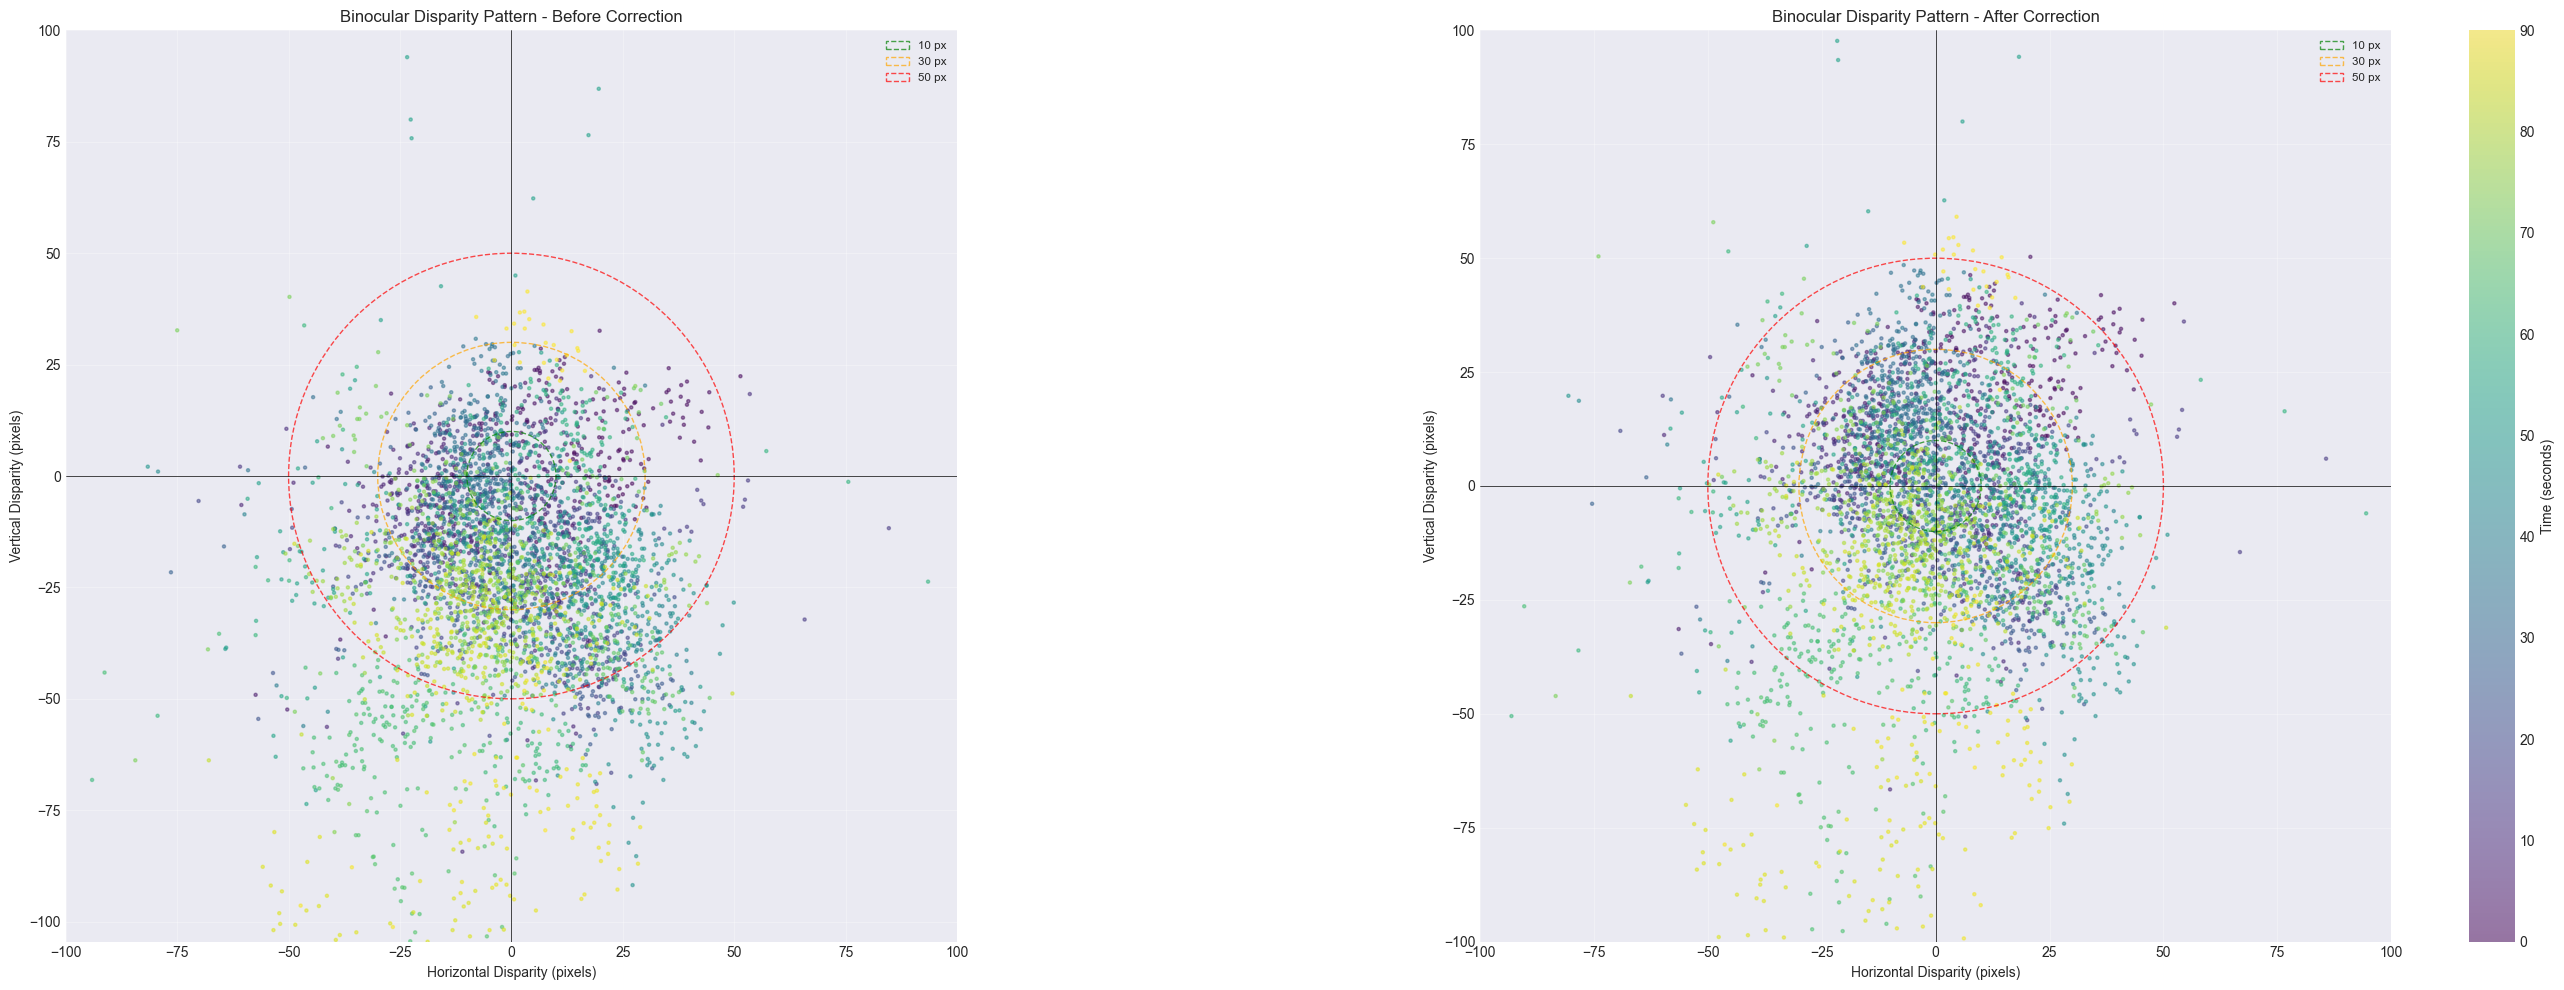

Disparity Statistics Comparison:
Metric                    Before          After           Change         
--------------------------------------------------
Mean Horizontal (px)      -1.9            -0.9            1.0            
Mean Vertical (px)        -27.9           -10.2           17.7           
Median Horizontal (px)    -1.4            -0.4            1.0            
Median Vertical (px)      -20.6           -2.9            17.7           

✅ Vertical bias improved!
✅ Horizontal bias improved!


In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# Plot before correction
scatter1, stats1 = plot_binocular_disparity_pattern(
    df_cleaned, ax=ax1, title_suffix="Before Correction"
)

# Plot after correction
scatter2, stats2 = plot_binocular_disparity_pattern(
    df_corrected, ax=ax2, title_suffix="After Correction"
)

# Add colorbar to the right of the second subplot
cbar = plt.colorbar(scatter2, ax=ax2, label='Time (seconds)')

plt.tight_layout()
plt.show()

# Print comparison statistics
print("Disparity Statistics Comparison:")
print("=" * 50)
print(f"{'Metric':<25} {'Before':<15} {'After':<15} {'Change':<15}")
print("-" * 50)
print(f"{'Mean Horizontal (px)':<25} {stats1['mean_x']:<15.1f} {stats2['mean_x']:<15.1f} {stats2['mean_x']-stats1['mean_x']:<15.1f}")
print(f"{'Mean Vertical (px)':<25} {stats1['mean_y']:<15.1f} {stats2['mean_y']:<15.1f} {stats2['mean_y']-stats1['mean_y']:<15.1f}")
print(f"{'Median Horizontal (px)':<25} {stats1['median_x']:<15.1f} {stats2['median_x']:<15.1f} {stats2['median_x']-stats1['median_x']:<15.1f}")
print(f"{'Median Vertical (px)':<25} {stats1['median_y']:<15.1f} {stats2['median_y']:<15.1f} {stats2['median_y']-stats1['median_y']:<15.1f}")

# Check improvement
if abs(stats2['mean_y']) < abs(stats1['mean_y']):
    print("\n✅ Vertical bias improved!")
else:
    print("\n⚠️ Vertical bias did not improve")

if abs(stats2['mean_x']) < abs(stats1['mean_x']):
    print("✅ Horizontal bias improved!")
else:
    print("⚠️ Horizontal bias did not improve")

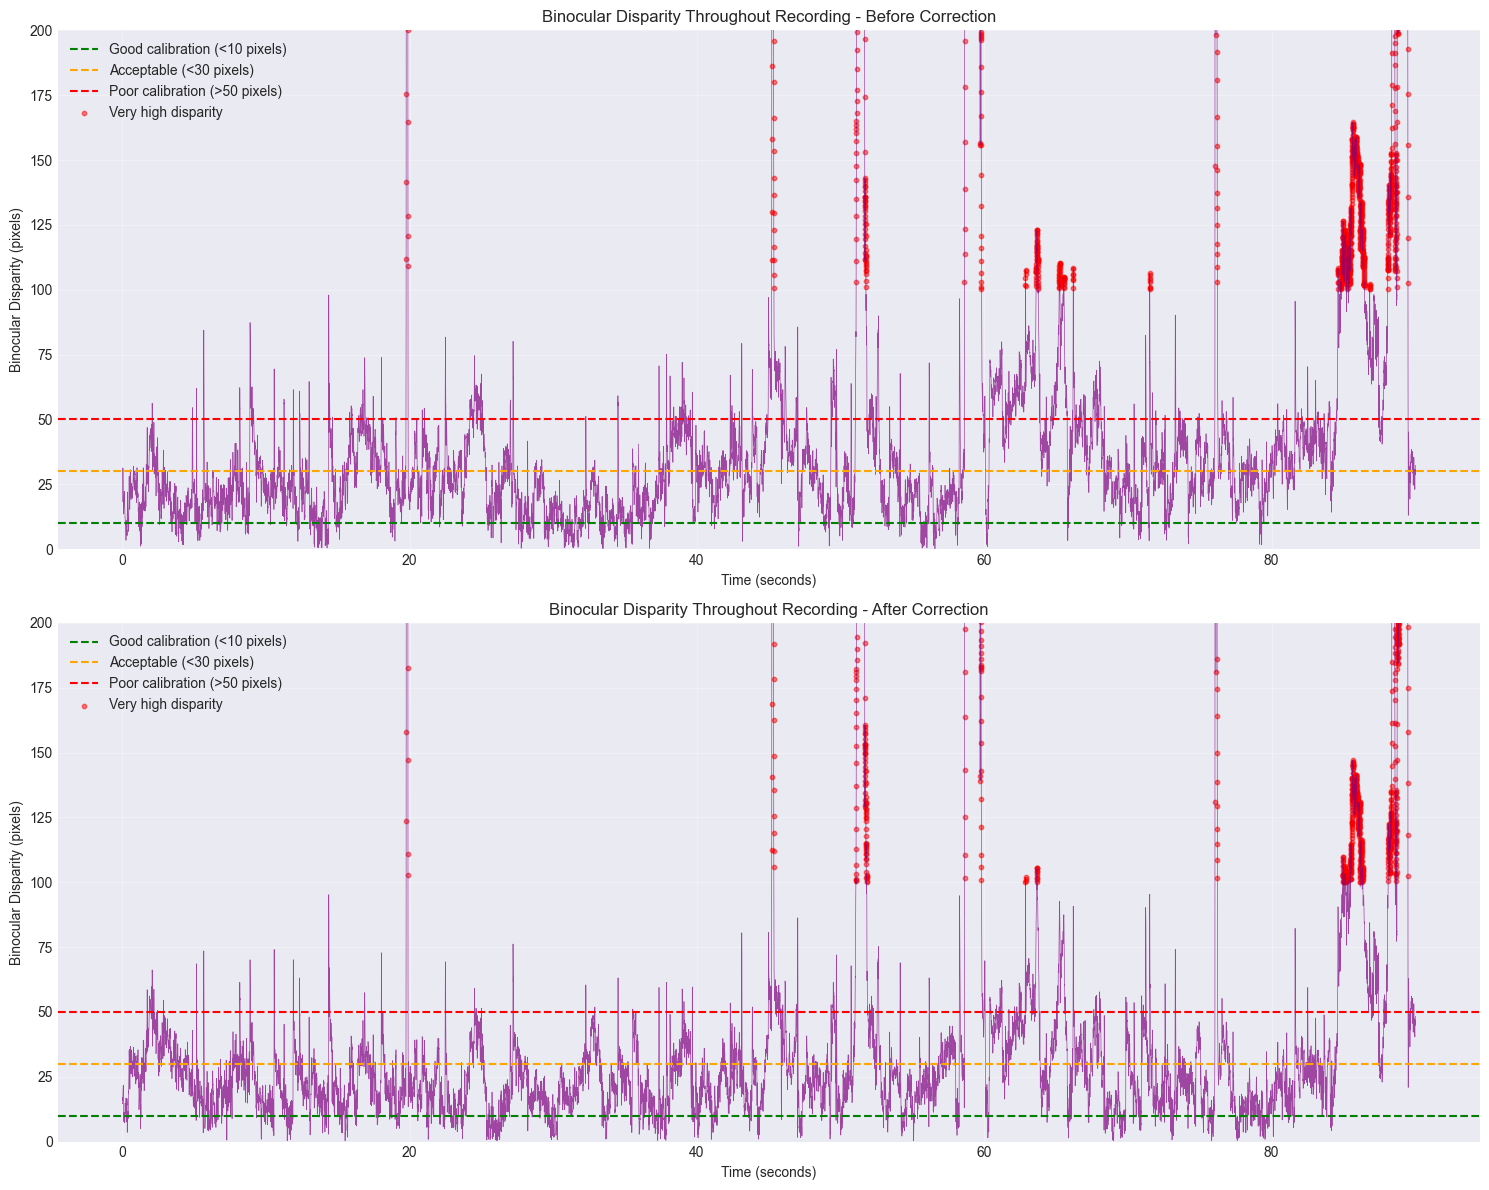

Disparity Statistics Comparison:
Metric                    Before          After           Change         
--------------------------------------------------
Mean disparity (px)       39.7            34.0            -5.7           
Median disparity (px)     28.8            24.4            -4.3           
% over 50px               18.0            11.2            -6.9           
% over 100px              4.3             3.2             -1.1           

✅ Overall disparity improved by 14.3%!


In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot before correction
stats1 = analyze_binocular_disparity(
    df_cleaned, ax=ax1, title_suffix="Before Correction"
)

# Plot after correction
stats2 = analyze_binocular_disparity(
    df_corrected, ax=ax2, title_suffix="After Correction"
)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("Disparity Statistics Comparison:")
print("=" * 50)
print(f"{'Metric':<25} {'Before':<15} {'After':<15} {'Change':<15}")
print("-" * 50)
print(f"{'Mean disparity (px)':<25} {stats1['mean_disparity']:<15.1f} {stats2['mean_disparity']:<15.1f} {stats2['mean_disparity']-stats1['mean_disparity']:<15.1f}")
print(f"{'Median disparity (px)':<25} {stats1['median_disparity']:<15.1f} {stats2['median_disparity']:<15.1f} {stats2['median_disparity']-stats1['median_disparity']:<15.1f}")
print(f"{'% over 50px':<25} {stats1['percent_over_50']:<15.1f} {stats2['percent_over_50']:<15.1f} {stats2['percent_over_50']-stats1['percent_over_50']:<15.1f}")
print(f"{'% over 100px':<25} {stats1['percent_over_100']:<15.1f} {stats2['percent_over_100']:<15.1f} {stats2['percent_over_100']-stats1['percent_over_100']:<15.1f}")

# Check improvement
improvement_pct = ((stats1['mean_disparity'] - stats2['mean_disparity']) / stats1['mean_disparity']) * 100
if improvement_pct > 0:
    print(f"\n✅ Overall disparity improved by {improvement_pct:.1f}%!")
else:
    print(f"\n⚠️ Overall disparity did not improve")
